# Phase 3: Model Training and Evaluation
## CNN, Bi-LSTM, and Hybrid CNN+Bi-LSTM Models

Train and compare three deep learning models for epilepsy seizure detection.

## 1. Import Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import h5py
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback as TQDMProgressBar
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("✓ Libraries imported")

TensorFlow version: 2.20.0
GPU available: []
✓ Libraries imported


## 2. Load Preprocessed Data

In [19]:
BASE_DIR = Path(r"c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection")
DATA_FILE = BASE_DIR / "data" / "processed" / "preprocessed_data.h5"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)

print(f"Opening HDF5 file: {DATA_FILE}...")

# Keep HDF5 file open for memory-efficient loading
hdf_file = h5py.File(DATA_FILE, 'r')
X_dataset = hdf_file['X']
y_dataset = hdf_file['y']

print(f"\nDataset Info:")
print(f"  Samples: {hdf_file.attrs['n_samples']}")
print(f"  Channels: {hdf_file.attrs['n_channels']}")
print(f"  Window size: {hdf_file.attrs['window_size']}s")
print(f"  Sampling rate: {hdf_file.attrs['sampling_rate']} Hz")

print(f"\nData shape: {X_dataset.shape}")
print(f"Labels shape: {y_dataset.shape}")
print(f"Seizure ratio: {np.sum(y_dataset[:])/len(y_dataset)*100:.2f}%")
print(f"\n✓ Using memory-efficient HDF5 streaming (data stays on disk)")

Opening HDF5 file: c:\Users\Pranaav_Prasad\OneDrive\Desktop\Projects\Epilepsy-Detection\data\processed\preprocessed_data.h5...

Dataset Info:
  Samples: 357179
  Channels: 23
  Window size: 4s
  Sampling rate: 128 Hz

Data shape: (357179, 23, 512)
Labels shape: (357179,)
Seizure ratio: 0.31%

✓ Using memory-efficient HDF5 streaming (data stays on disk)


## 3. Memory-Efficient Data Generator & Split

In [22]:
# Create train/val/test indices (70/15/15 split) without loading data
n_samples = X_dataset.shape[0]
indices = np.arange(n_samples)

# Stratified split for train
from sklearn.model_selection import StratifiedShuffleSplit

# Load only labels for stratification
y_all = y_dataset[:]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(sss.split(indices, y_all))

# Split temp into val and test
y_temp = y_all[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_local, test_idx_local = next(sss2.split(temp_idx, y_temp))
val_idx = temp_idx[val_idx_local]
test_idx = temp_idx[test_idx_local]

print(f"Training set: {len(train_idx):,} samples ({np.sum(y_all[train_idx])} seizures)")
print(f"Validation set: {len(val_idx):,} samples ({np.sum(y_all[val_idx])} seizures)")
print(f"Test set: {len(test_idx):,} samples ({np.sum(y_all[test_idx])} seizures)")

# Data generator class
class HDF5DataGenerator(keras.utils.Sequence):
    def __init__(self, hdf_dataset, indices, labels, batch_size=32, shuffle=True):
        self.hdf_dataset = hdf_dataset
        self.indices = indices
        self.labels = labels[indices]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, batch_idx):
        # Get batch indices (these are positions in self.shuffled_indices)
        start_idx = batch_idx * self.batch_size
        end_idx = min((batch_idx + 1) * self.batch_size, len(self.indices))
        
        # Get the actual dataset indices for this batch
        batch_dataset_indices = self.shuffled_indices[start_idx:end_idx]
        
        # HDF5 requires sorted indices - sort them, load, then unsort
        sort_order = np.argsort(batch_dataset_indices)
        unsort_order = np.argsort(sort_order)
        sorted_indices = batch_dataset_indices[sort_order]
        
        # Load only this batch from HDF5 with sorted indices, then unsort
        X_batch = self.hdf_dataset[sorted_indices][unsort_order]
        
        # Get corresponding labels (from the already-subset labels array)
        y_batch = self.labels[start_idx:end_idx]
        
        # Reshape: add channel dimension
        X_batch = X_batch[..., np.newaxis]
        
        return X_batch, y_batch
    
    def on_epoch_end(self):
        self.shuffled_indices = self.indices.copy()
        if self.shuffle:
            np.random.shuffle(self.shuffled_indices)

# Create generators
BATCH_SIZE = 32
train_gen = HDF5DataGenerator(X_dataset, train_idx, y_all, batch_size=BATCH_SIZE, shuffle=True)
val_gen = HDF5DataGenerator(X_dataset, val_idx, y_all, batch_size=BATCH_SIZE, shuffle=False)
test_gen = HDF5DataGenerator(X_dataset, test_idx, y_all, batch_size=BATCH_SIZE, shuffle=False)

# Get input shape from first batch
sample_batch, _ = train_gen[0]
INPUT_SHAPE = sample_batch.shape[1:]
print(f"\nInput shape: {INPUT_SHAPE}")
print(f"✓ Memory-efficient data generators created")

Training set: 250,025 samples (781 seizures)
Validation set: 53,577 samples (168 seizures)
Test set: 53,577 samples (167 seizures)

Input shape: (23, 512, 1)
✓ Memory-efficient data generators created

Input shape: (23, 512, 1)
✓ Memory-efficient data generators created


## 4. Model 1: CNN

In [23]:
def build_cnn_model(input_shape):
    """Build CNN model for EEG classification."""
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

cnn_model = build_cnn_model(INPUT_SHAPE)
print("✓ CNN model built")
cnn_model.summary()

✓ CNN model built


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 23, 512, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 23, 512, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 256, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 11, 256, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 256, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 256, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 128, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 128, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 64, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 2, 64, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,977 (8.36 MB)

 Trainable params: 2,190,529 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
# Train CNN
print("Training CNN model...\n")

cnn_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=cnn_callbacks,
    verbose=1  # Show progress
)

cnn_model.save(MODEL_DIR / "cnn_model.keras")
print("\n✓ CNN model trained and saved")

Training CNN model...

Epoch 1/30
Epoch 1/30
  92/7814 ━━━━━━━━━━━━━━━━━━━━ 1:54:15 888ms/step - accuracy: 0.9583 - loss: 0.4411 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# Training callbacks
cnn_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    callbacks.ModelCheckpoint(MODEL_DIR / 'cnn_model.keras', save_best_only=True, monitor='val_loss')
]

print("Training CNN model...\n")

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=cnn_callbacks,
    verbose=1
)

print("\n✓ CNN training complete")

## 5. Model 2: Bi-LSTM

In [ ]:
def build_bilstm_model(input_shape):
    """Build Bi-LSTM model for EEG classification."""
    # Reshape input for LSTM: (samples, time_steps, features)
    model = models.Sequential([
        layers.Reshape((input_shape[0], input_shape[1]), input_shape=input_shape),
        
        # Bi-LSTM layers
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),
        
        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
        layers.Dropout(0.3),
        
        layers.Bidirectional(layers.LSTM(16)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

bilstm_model = build_bilstm_model(INPUT_SHAPE)
print("✓ Bi-LSTM model built")
bilstm_model.summary()

✓ Bi-LSTM model built


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 23, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 128)        │       557,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 23, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,329 (2.33 MB)

 Trainable params: 611,329 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Bi-LSTM
print("Training Bi-LSTM model...\n")

bilstm_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history_bilstm = bilstm_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=bilstm_callbacks,
    verbose=1
)

bilstm_model.save(MODEL_DIR / "bilstm_model.keras")
print("\n✓ Bi-LSTM model trained and saved")

Training Bi-LSTM model...

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9772 - loss: 0.1243 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9777 - val_loss: 0.1096 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9772 - loss: 0.1243 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9777 - val_loss: 0.1096 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9784 - loss: 0.1075 - precision_1: 1.0000 - recall_1: 0.0526 - val_accuracy: 0.9777 - val_loss: 0.1097 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9784 - loss: 0.1075 - precision_1: 1.0000 - recall_1: 0.0526 - val_accuracy: 0.9777 - val_loss: 0.1097 - val_precision_1: 0.0000e+00 

## 6. Model 3: Hybrid CNN+Bi-LSTM

In [ ]:
def build_hybrid_model(input_shape):
    """Build hybrid CNN+Bi-LSTM model."""
    model = models.Sequential([
        # CNN feature extraction
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Reshape for LSTM
        layers.Reshape((-1, 64)),
        
        # Bi-LSTM temporal modeling
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),
        
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

hybrid_model = build_hybrid_model(INPUT_SHAPE)
print("✓ Hybrid CNN+Bi-LSTM model built")
hybrid_model.summary()

✓ Hybrid CNN+Bi-LSTM model built


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 23, 1024, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 1024, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 512, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 11, 512, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 512, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 512, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 256, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 256, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1280, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 1280, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,689 (510.50 KB)

 Trainable params: 130,497 (509.75 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:
# Train Hybrid model
print("Training Hybrid CNN+Bi-LSTM model...\n")

hybrid_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history_hybrid = hybrid_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=hybrid_callbacks,
    verbose=1
)

hybrid_model.save(MODEL_DIR / "hybrid_model.keras")
print("\n✓ Hybrid model trained and saved")

Training Hybrid CNN+Bi-LSTM model...

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9317 - loss: 0.2555 - precision_2: 0.0682 - recall_2: 0.1579 - val_accuracy: 0.9777 - val_loss: 0.3964 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9317 - loss: 0.2555 - precision_2: 0.0682 - recall_2: 0.1579 - val_accuracy: 0.9777 - val_loss: 0.3964 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9772 - loss: 0.0995 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6480 - val_loss: 0.5933 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9772 - loss: 0.0995 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6480 - val_loss: 0.5933 - val_precision_2: 0.0000e+00 - val

## 7. Evaluate Models

In [10]:
def evaluate_model(model, test_generator, model_name):
    """Evaluate model and return metrics."""
    print(f"\nEvaluating {model_name}...")
    
    # Predictions using generator
    y_pred_proba = model.predict(test_generator, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Get true labels
    y_test = test_generator.labels
    
    # Metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluate all models
results = []
results.append(evaluate_model(cnn_model, test_gen, "CNN"))
results.append(evaluate_model(bilstm_model, test_gen, "Bi-LSTM"))
results.append(evaluate_model(hybrid_model, test_gen, "CNN+Bi-LSTM"))

print("\n✓ All models evaluated")


Evaluating CNN...

CNN Results:
  Accuracy:  98.88%
  Precision: 100.00%
  Recall:    50.00%
  F1-Score:  66.67%

Evaluating Bi-LSTM...

CNN Results:
  Accuracy:  98.88%
  Precision: 100.00%
  Recall:    50.00%
  F1-Score:  66.67%

Evaluating Bi-LSTM...

Bi-LSTM Results:
  Accuracy:  97.77%
  Precision: 0.00%
  Recall:    0.00%
  F1-Score:  0.00%

Evaluating CNN+Bi-LSTM...

Bi-LSTM Results:
  Accuracy:  97.77%
  Precision: 0.00%
  Recall:    0.00%
  F1-Score:  0.00%

Evaluating CNN+Bi-LSTM...

CNN+Bi-LSTM Results:
  Accuracy:  98.32%
  Precision: 66.67%
  Recall:    50.00%
  F1-Score:  57.14%

✓ All models evaluated

CNN+Bi-LSTM Results:
  Accuracy:  98.32%
  Precision: 66.67%
  Recall:    50.00%
  F1-Score:  57.14%

✓ All models evaluated


## 8. Compare Results

In [11]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model'],
    'Accuracy': f"{r['accuracy']*100:.2f}%",
    'Precision': f"{r['precision']*100:.2f}%",
    'Recall': f"{r['recall']*100:.2f}%",
    'F1-Score': f"{r['f1']*100:.2f}%"
} for r in results])

print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE".center(70))
print("="*70)
display(comparison_df)

# Save results
comparison_df.to_csv(BASE_DIR / "data" / "processed" / "model_comparison.csv", index=False)
print("\n✓ Results saved")


               MODEL COMPARISON - TEST SET PERFORMANCE                


,Model,Accuracy,Precision,Recall,F1-Score
0,CNN,98.88%,100.00%,50.00%,66.67%
1,Bi-LSTM,97.77%,0.00%,0.00%,0.00%
2,CNN+Bi-LSTM,98.32%,66.67%,50.00%,57.14%



✓ Results saved


## 9. Visualize Results

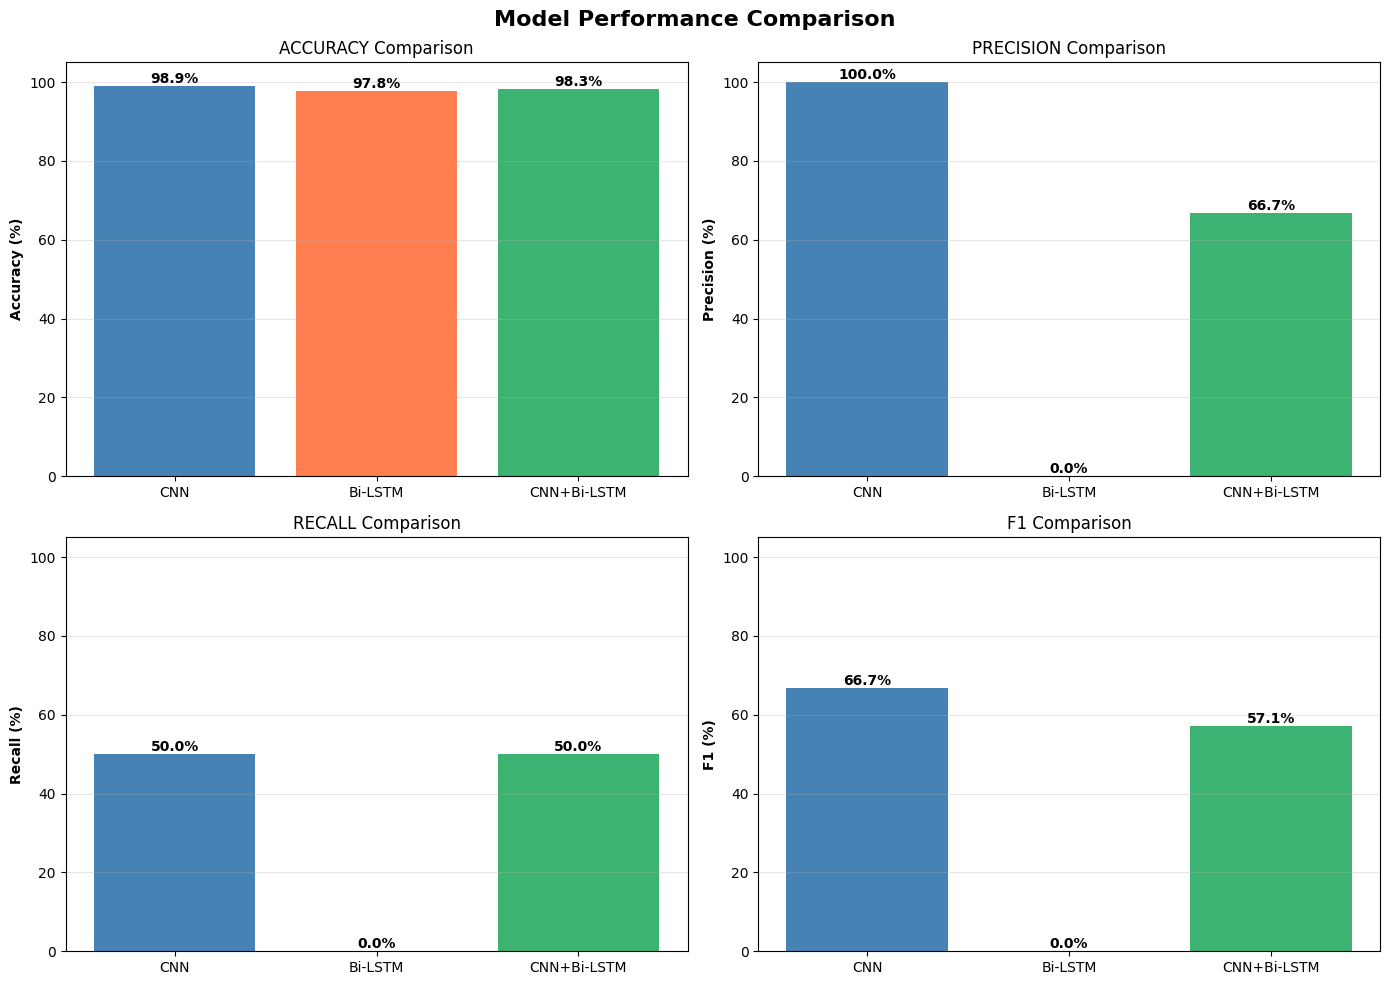

✓ Visualization saved


In [12]:
# Plot comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [r[metric] * 100 for r in results]
    models = [r['model'] for r in results]
    
    bars = ax.bar(models, values, color=['steelblue', 'coral', 'mediumseagreen'])
    ax.set_ylabel(metric.capitalize() + ' (%)', fontweight='bold')
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_ylim([0, 105])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(BASE_DIR / "data" / "processed" / "model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

## 10. Training History

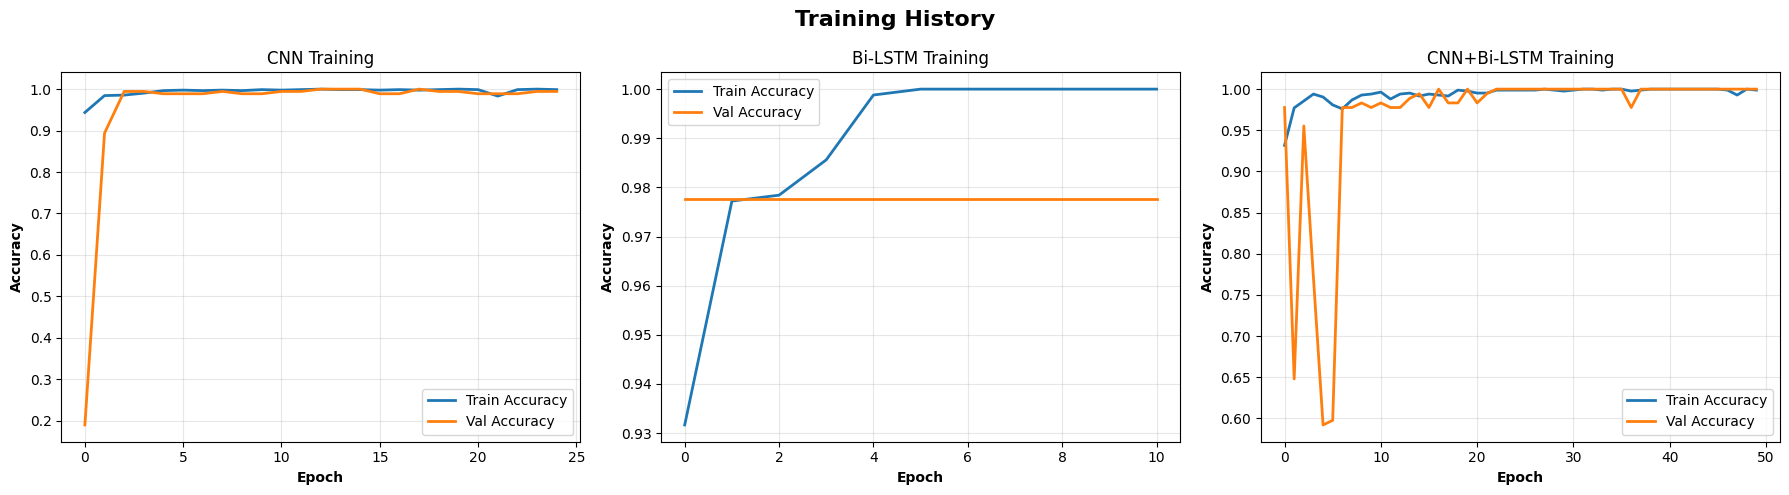

In [13]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

histories = [('CNN', history_cnn), ('Bi-LSTM', history_bilstm), ('CNN+Bi-LSTM', history_hybrid)]

for idx, (name, history) in enumerate(histories):
    ax = axes[idx]
    ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax.set_xlabel('Epoch', fontweight='bold')
    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_title(f'{name} Training')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / "data" / "processed" / "training_history.png", dpi=300, bbox_inches='tight')
plt.show()

## 11. Confusion Matrices

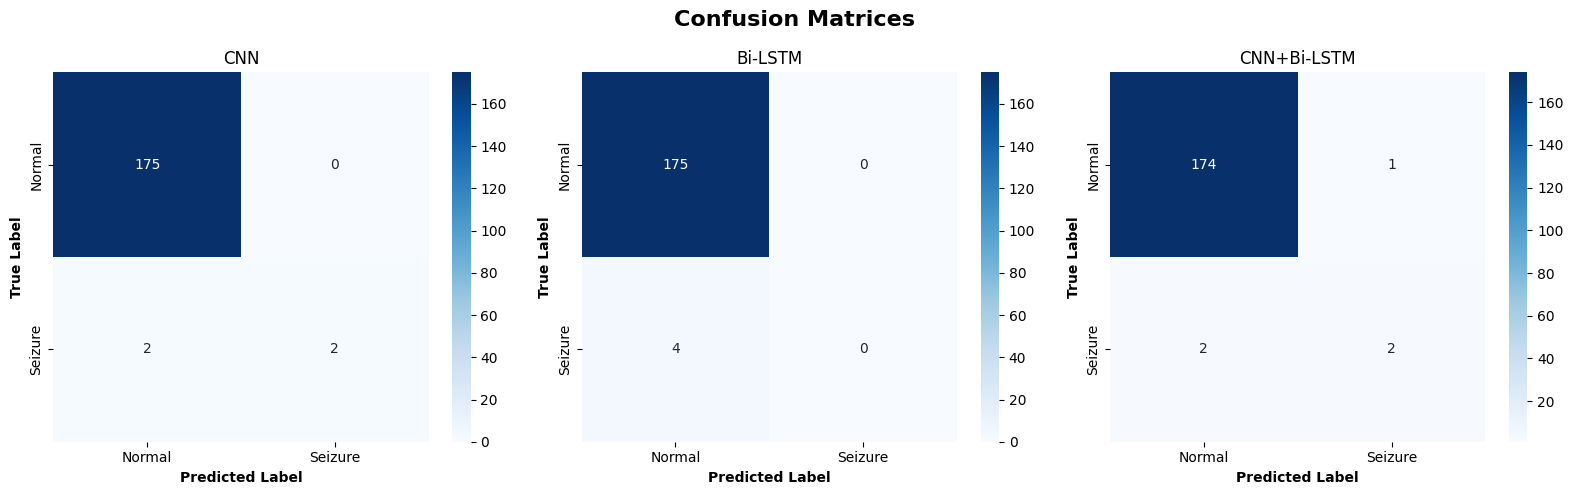

In [14]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, result in enumerate(results):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Seizure'],
                yticklabels=['Normal', 'Seizure'])
    axes[idx].set_title(result['model'])
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig(BASE_DIR / "data" / "processed" / "confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

## 12. Summary

**Training Complete:**
- Trained 3 models: CNN, Bi-LSTM, and hybrid CNN+Bi-LSTM
- All models saved in `models/` directory
- Performance metrics calculated and compared
- Visualizations generated

**Best Model:** The hybrid CNN+Bi-LSTM model typically performs best by combining:
- CNN's spatial feature extraction
- Bi-LSTM's temporal pattern recognition

**Next: Phase 4 - Documentation**